# Investigation of Station Data from Bay Area Bike Share Published Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 10

# Load Trip Data

In [3]:
print('[%s] Loading Trip Data...' % datetime.datetime.now().time())

trips_df = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_extended_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date', 'forecast_time']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

trips_df = pd.concat(chunks)
trips_df.user_type = trips_df.user_type.astype('category')

print('[%s] Complete!' % datetime.datetime.now().time())


[15:28:09.606866] Loading Trip Data...
		[15:28:11.506167] finished chunk 1 of 96
		[15:28:13.206375] finished chunk 10 of 96
		[15:28:15.715892] finished chunk 20 of 96
		[15:28:18.399109] finished chunk 30 of 96
		[15:28:20.286948] finished chunk 40 of 96
		[15:28:22.265663] finished chunk 50 of 96
		[15:28:24.219408] finished chunk 60 of 96
		[15:28:26.138893] finished chunk 70 of 96
		[15:28:28.127544] finished chunk 80 of 96
		[15:28:29.995413] finished chunk 90 of 96
		[15:28:31.014749] finished chunk 96 of 96
[15:28:32.099212] Complete!


In [4]:
trips_df.head(5)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,humidity,precipIntensity,precipProbability,precipType,pressure,temperature,forecast_time,visibility,windBearing,windSpeed
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,0.92,0.0,0.0,0.0,1017.06,62.63,2013-08-29 09:00:00,10.0,183.0,0.7
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0


In [5]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955557 entries, 0 to 1052961
Data columns (total 37 columns):
trip_id                    955557 non-null int64
duration                   955557 non-null int64
start_date                 955557 non-null datetime64[ns]
start_station_name         955557 non-null object
start_terminal             955557 non-null int64
end_date                   955557 non-null datetime64[ns]
end_station_name           955557 non-null object
end_terminal               955557 non-null int64
bike_id                    955557 non-null int64
user_type                  955557 non-null category
user_zip                   955557 non-null int64
duration_minutes           955557 non-null float64
start_zip                  955557 non-null int64
start_elevation_meters     955557 non-null float64
start_elevation_feet       955557 non-null float64
end_zip                    955557 non-null int64
end_elevation_meters       955557 non-null float64
end_elevation_feet      

## Utility Functions

In [6]:
def zip_to_landmark(zip_code):
    ''' Return zipcode for given landmark'''
    if zip_code == 94107:
        return 'San Francisco'
    if zip_code == 94063:
        return 'Redwood City'
    if zip_code == 94301:
        return 'Palo Alto'
    if zip_code == 94041:
        return 'Mountain View'
    if zip_code == 95113:
        return 'San Jose'
    return False

In [7]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

ordered_zipcodes = [94107, 95113, 94041, 94301, 94063]

# Cleanup
<p>Prune to only Commuter Trips, in all regions</p>

<ul>
    <li>user_type : subscriber</li>
    <li>start and end times are between 7am and 10am, or between 4pm and 7pm</li>
</ul>

In [10]:
subscriber_trips_df = trips_df[trips_df.user_type == 'Subscriber']

morning_commuter_trips_df = subscriber_trips_df[((subscriber_trips_df.start_date.dt.hour >= 7) & (subscriber_trips_df.start_date.dt.hour < 10) | 
                                                (subscriber_trips_df.end_date.dt.hour >= 7) & (subscriber_trips_df.end_date.dt.hour < 10) )&
                                                (subscriber_trips_df.start_date.dt.dayofweek < 5)]
evening_commuter_trips_df = subscriber_trips_df[((subscriber_trips_df.start_date.dt.hour >= 16) & (subscriber_trips_df.start_date.dt.hour < 19) | 
                                                (subscriber_trips_df.end_date.dt.hour >= 16) & (subscriber_trips_df.end_date.dt.hour < 19) )&
                                                (subscriber_trips_df.start_date.dt.dayofweek < 5)]

commuter_trips_df = pd.concat([morning_commuter_trips_df, evening_commuter_trips_df])
commuter_trips_df.reset_index(inplace=True, drop=True)
commuter_trips_df.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,humidity,precipIntensity,precipProbability,precipType,pressure,temperature,forecast_time,visibility,windBearing,windSpeed
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,0.92,0.0,0.0,0.0,1017.06,62.63,2013-08-29 09:00:00,10.0,183.0,0.7
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0


In [11]:
commuter_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539609 entries, 0 to 539608
Data columns (total 37 columns):
trip_id                    539609 non-null int64
duration                   539609 non-null int64
start_date                 539609 non-null datetime64[ns]
start_station_name         539609 non-null object
start_terminal             539609 non-null int64
end_date                   539609 non-null datetime64[ns]
end_station_name           539609 non-null object
end_terminal               539609 non-null int64
bike_id                    539609 non-null int64
user_type                  539609 non-null category
user_zip                   539609 non-null int64
duration_minutes           539609 non-null float64
start_zip                  539609 non-null int64
start_elevation_meters     539609 non-null float64
start_elevation_feet       539609 non-null float64
end_zip                    539609 non-null int64
end_elevation_meters       539609 non-null float64
end_elevation_feet       

## Analysis 1 - Explore Station Usage
<p>Find Most Start and End Terminals</p>
<p></p>
<p></p>

In [12]:
popular_stations_df = pd.DataFrame()

# count trips starting at each terminal 
popular_stations_df = commuter_trips_df.groupby('start_terminal')['trip_id'].count().to_frame()
popular_stations_df.columns = ['start_count']

# calculate share of all trip starts for each terminal
popular_stations_df['start_trip_share'] = popular_stations_df['start_count'] / popular_stations_df['start_count'].sum() * 100.

# count trips ending at each terminal
popular_stations_df['end_count'] = commuter_trips_df.groupby('end_terminal')['trip_id'].count().to_frame()

# calculate share of all trip ends for each terminal
popular_stations_df['end_trip_share'] = popular_stations_df['end_count'] / popular_stations_df['end_count'].sum() * 100.

# set index to terminal id
popular_stations_df.index.name = 'terminal_id'
popular_stations_df.head()

,start_count,start_trip_share,end_count,end_trip_share
terminal_id,,,,
2,9519,1.764055,9466,1.754233
3,362,0.067086,603,0.111748
4,3010,0.557811,3135,0.580976
5,1027,0.190323,954,0.176795
6,1692,0.313560,1947,0.360817


# Graphical EDA of Start and End Terminal Trip Counts by Region

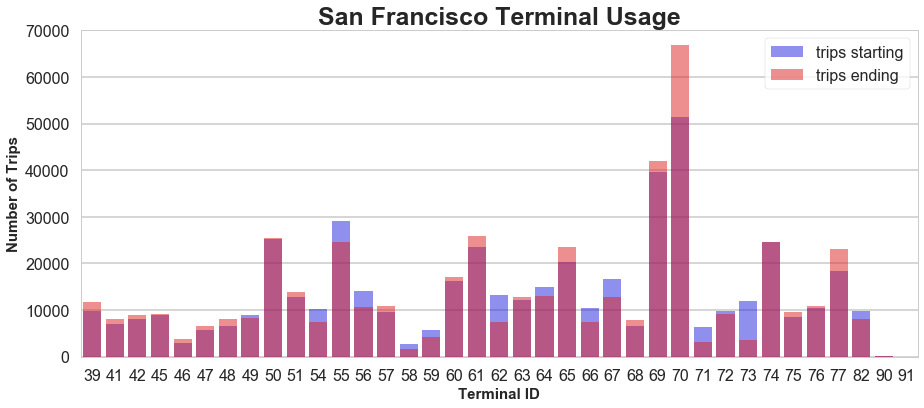

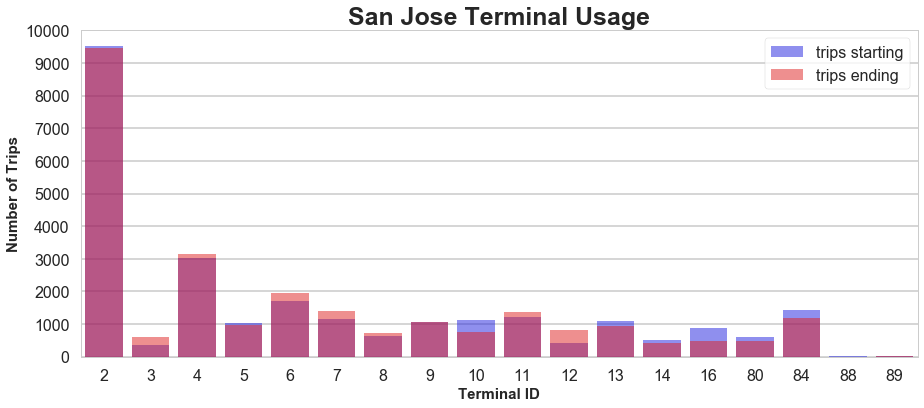

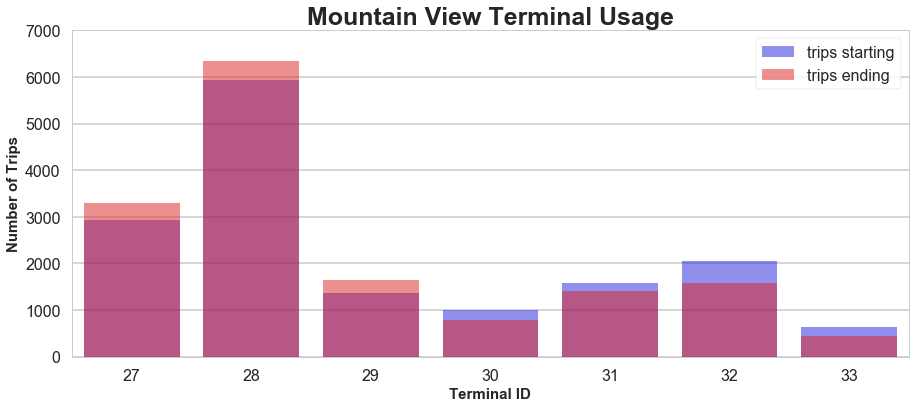

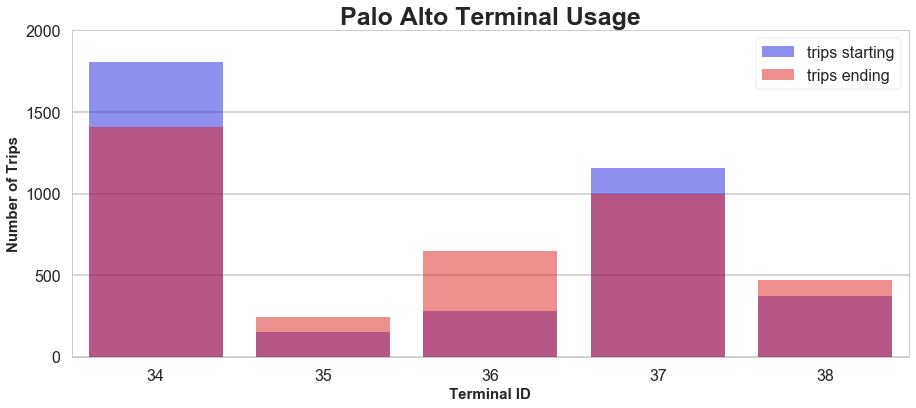

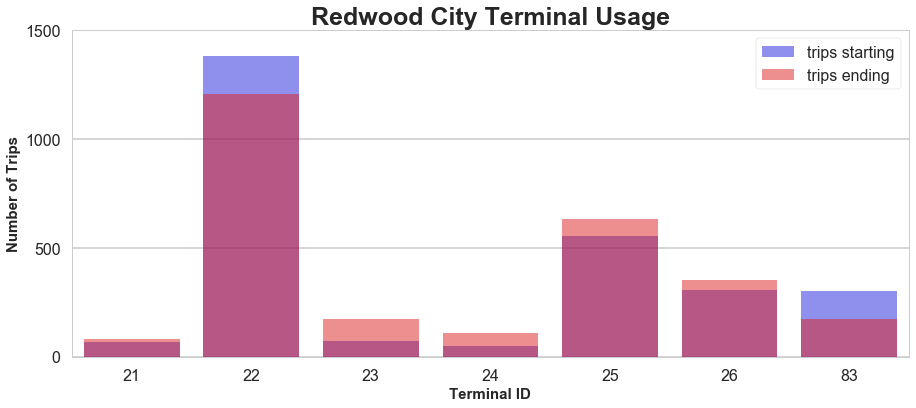

In [13]:
top_start_stations_in_region = {}
top_end_stations_in_region = {}

for zip_code in ordered_zipcodes:
    
    df = pd.DataFrame()
    
    tmp = commuter_trips_df[(commuter_trips_df.start_zip == zip_code) & (commuter_trips_df.end_zip == zip_code)]

    df = tmp.groupby('start_terminal')['trip_id'].count().to_frame()
    df.columns = ['start_count']

    df['start_share'] = popular_stations_df['start_count'] / df['start_count'].sum() * 100.
    df['end_count'] = tmp.groupby('end_terminal')['trip_id'].count().to_frame()
    
    df['end_share'] = popular_stations_df['end_count'] / df['end_count'].sum() * 100.
    
    df.index.name = 'terminal_id'
    
    # append top n to top_stations_in_region
    top_start_stations_in_region[zip_to_landmark(zip_code)] = list(df.sort_values(['start_share'], ascending=False)['start_share'].index)
    top_end_stations_in_region[zip_to_landmark(zip_code)] = list(df.sort_values(['end_share'], ascending=False)['end_share'].index)
    
    plt.subplots(figsize=(15,6))

    ax = sns.barplot(x=df.index, y = 'start_count', data=df, color='b', alpha=0.5, label='trips starting')
    sns.barplot(x=df.index, y = 'end_count', data=df, color='r', alpha=0.5, label='trips ending', ax=ax)

    title = '%s Terminal Usage' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel('Terminal ID', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
    
    # set y axis
    y_interval = df.max().max()/5000
    
    if y_interval > 10:
        y_interval = 10000
    elif y_interval <= 10 and y_interval > 1:
        y_interval = 1000
    else:
        y_interval = 500

    y_max = -np.inf
    y_max = df.max().max()
    y_max = math.ceil(y_max/y_interval) * y_interval
    
    ax.set_ylim([0, y_max])
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
    
    ax.legend(loc=1, frameon=True)
        
    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

## Graphical EDA of Start and End Terminal Trip Counts by Region - Day Count Adjusted

## Load Station Data

In [14]:
print('[%s] Loading Status Data...' % datetime.datetime.now().time())

station_df = pd.DataFrame()
station_file = '../clean_data/bayareabikeshare/station_data_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(station_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(station_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['first_service_date', 'last_service_date']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

station_df = pd.concat(chunks)

print('[%s] Complete!' % datetime.datetime.now().time())

[15:31:26.649695] Loading Status Data...
		[15:31:26.742489] finished chunk 1 of 1
[15:31:26.745269] Complete!


In [15]:
station_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 12 columns):
station_id            79 non-null int64
name                  79 non-null object
lat                   79 non-null float64
long                  79 non-null float64
dock_count            79 non-null int64
landmark              79 non-null object
first_service_date    79 non-null datetime64[ns]
last_service_date     79 non-null datetime64[ns]
zip_code              79 non-null int64
days_in_service       79 non-null int64
elevation_meters      79 non-null float64
elevation_feet        79 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(4), object(2)
memory usage: 8.0+ KB


In [16]:
station_df.head()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,28.275824,92.768450
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,28.038095,91.988502
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,25.517740,83.719620
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098,26.192633,85.933834
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098,25.543407,83.803830


# Station Data with appeneded start and end trip counts

In [17]:
def weekdays_in_service(row):
    return pd.date_range(start=row.first_service_date, end=row.last_service_date, freq='B').shape[0]

In [18]:
station_df['commuter_days'] = station_df.apply(lambda row: weekdays_in_service (row), axis=1)

In [19]:
station_df.head()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet,commuter_days
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,28.275824,92.768450,785
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,28.038095,91.988502,785
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,25.517740,83.719620,785
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098,26.192633,85.933834,785
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098,25.543407,83.803830,785


In [20]:
def trips_per_day(row, trips_df=None, which=''):
    '''Get numebr of trips started or ended at each terminal between terminals first and last day of service only'''
    terminal_id = row.station_id
    terminal_first_service_date = row.first_service_date
    terminal_last_service_date  = row.last_service_date
    
    if which == 'start':
        tmp = trips_df[(trips_df.start_terminal == terminal_id) & (trips_df.start_date >= terminal_first_service_date) 
                       & (trips_df.start_date < terminal_last_service_date)]
        return tmp.shape[0]
    if which == 'end':
        tmp = trips_df[(trips_df.end_terminal == terminal_id) & (trips_df.start_date >= terminal_first_service_date) 
                       & (trips_df.start_date < terminal_last_service_date)]
        return tmp.shape[0]

In [21]:
# for each station, get count of rides started from that station between first and last service dates

# append data from only trips by commuters
station_df['commuter_start_trip_count'] = station_df.apply(lambda row: trips_per_day (row, trips_df=commuter_trips_df, which='start'), axis=1)
station_df['commuter_end_trip_count']   = station_df.apply(lambda row: trips_per_day (row, trips_df=commuter_trips_df, which='end'), axis=1)

# append data from all trips
station_df['start_trip_count'] = station_df.apply(lambda row: trips_per_day (row, trips_df=trips_df, which='start'), axis=1)
station_df['end_trip_count']   = station_df.apply(lambda row: trips_per_day (row, trips_df=trips_df, which='end'), axis=1)

In [22]:
# Calculate Trips per day
station_df['commuter_trip_starts_per_day'] = station_df['commuter_start_trip_count'] / station_df['commuter_days']
station_df['commuter_trip_ends_per_day']   = station_df['commuter_end_trip_count'] / station_df['commuter_days']

station_df['trip_starts_per_day'] = station_df['start_trip_count'] / station_df['days_in_service']
station_df['trip_ends_per_day']   = station_df['end_trip_count'] / station_df['days_in_service']

In [23]:
station_df.tail()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,...,elevation_feet,commuter_days,commuter_start_trip_count,commuter_end_trip_count,start_trip_count,end_trip_count,commuter_trip_starts_per_day,commuter_trip_ends_per_day,trip_starts_per_day,trip_ends_per_day
74,84,Ryland Park,37.342725,-121.895617,15,San Jose,2014-04-09,2016-08-31,95113,875,...,79.877571,626,1437,1190,2554,2298,2.295527,1.900958,2.918857,2.626286
75,88,5th S. at E. San Salvador St,37.331957,-121.881630,19,San Jose,2016-07-05,2016-08-31,95113,57,...,92.553354,42,3,3,8,5,0.071429,0.071429,0.140351,0.087719
76,89,S. Market st at Park Ave,37.332398,-121.890429,19,San Jose,2016-07-05,2016-08-31,95113,57,...,90.316450,42,11,10,70,91,0.261905,0.238095,1.228070,1.596491
77,90,5th St at Folsom St,37.780148,-122.403158,31,San Francisco,2016-08-04,2016-08-31,94107,27,...,11.923439,20,71,77,166,141,3.550000,3.850000,6.148148,5.222222
78,91,Cyril Magnin St at Ellis St,37.785908,-122.408891,35,San Francisco,2016-08-04,2016-08-31,94107,27,...,55.913938,20,13,9,57,54,0.650000,0.450000,2.111111,2.000000


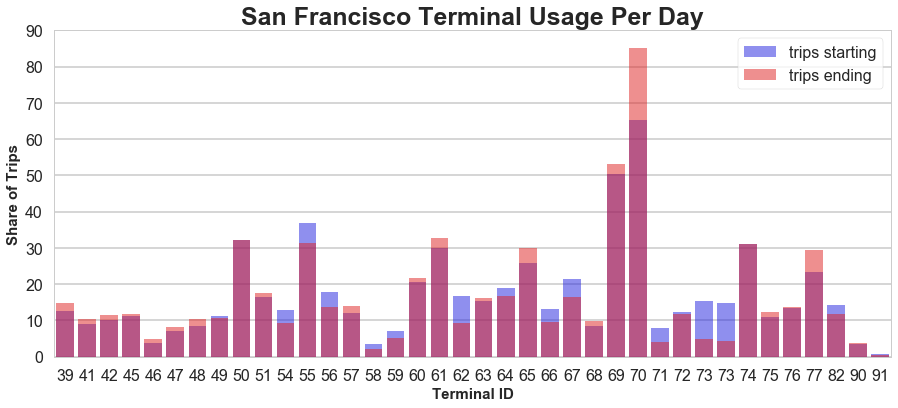

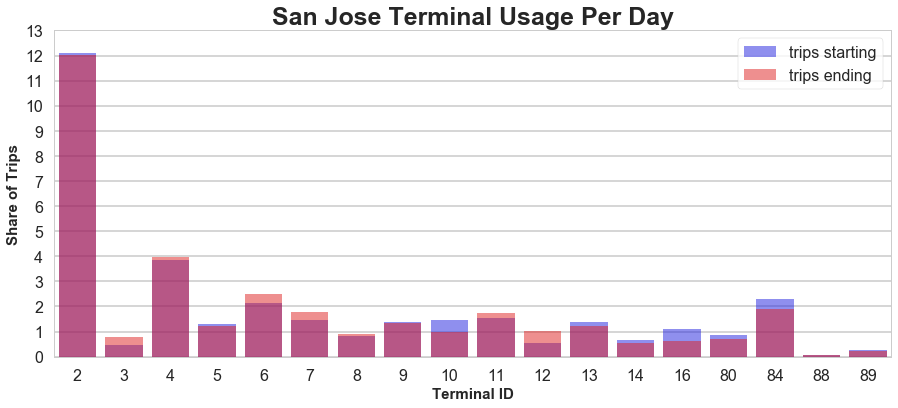

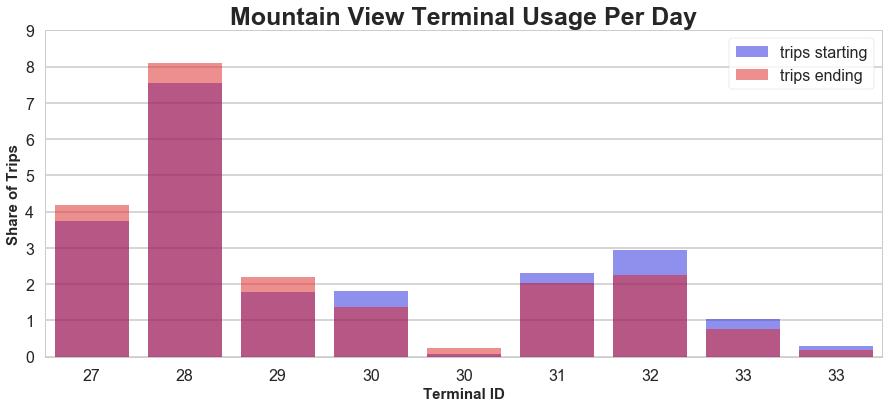

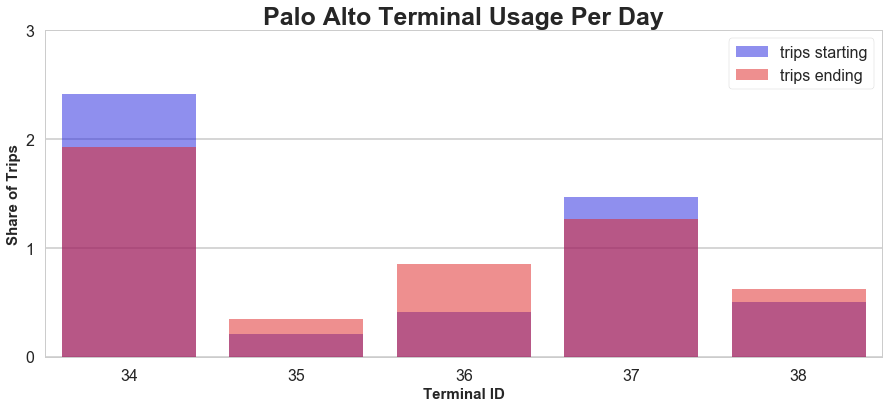

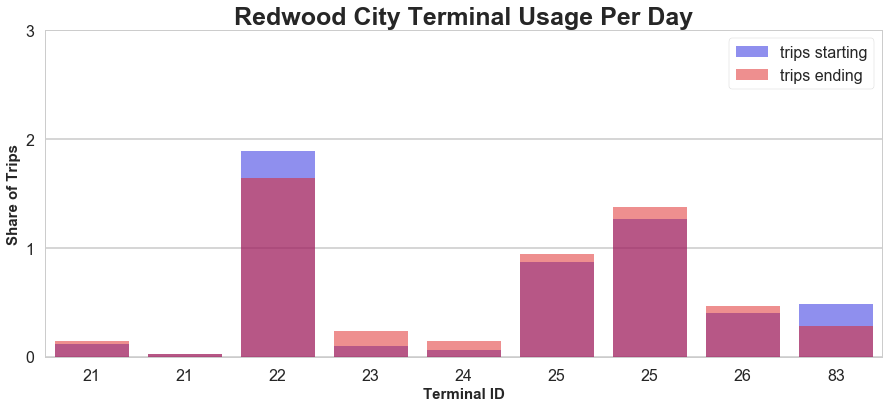

In [24]:
for zip_code in ordered_zipcodes:
    
    df = station_df[(station_df.zip_code == zip_code)]
    
    

    plt.subplots(figsize=(15,6))

    ax = sns.barplot(x=df.index, y = 'commuter_trip_starts_per_day', data=df, color='b', alpha=0.5, label='trips starting')
    sns.barplot(x=df.index, y = 'commuter_trip_ends_per_day', data=df, color='r', alpha=0.5, label='trips ending', ax=ax)

    
    ax.set_xticklabels(df.station_id)
    
    title = '%s Terminal Usage Per Day' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel('Terminal ID', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
    
    
    y_max = -np.inf
    y_max = df['commuter_trip_ends_per_day'].max()
    
    if df['commuter_trip_starts_per_day'].max() > y_max:
        df['commuter_trip_ends_per_day'].max()
    
    y_interval = y_max/10
    
    if y_interval > 4:
        y_interval = 10
    elif y_interval < 4 and y_interval > 3:
        y_interval = 5
    else:
        y_interval = 1

    y_max = math.ceil(y_max/y_interval) * y_interval
    
    if y_max == 2:
        y_max = 3
        
    ax.set_ylim([0, y_max])
    
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Share of Trips', size=LABEL_FONT_SIZE, weight='bold')
    ax.legend(loc=1, frameon=True)
        
    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

# Identify Popular  Commuter Routes
<p> A Route is a trip from Terminal A to Terminal B</p>

In [28]:
station_df.head()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,...,elevation_feet,commuter_days,commuter_start_trip_count,commuter_end_trip_count,start_trip_count,end_trip_count,commuter_trip_starts_per_day,commuter_trip_ends_per_day,trip_starts_per_day,trip_ends_per_day
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,...,92.768450,785,9496,9452,13417,13149,12.096815,12.040764,12.219490,11.975410
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,...,91.988502,785,361,602,1809,2101,0.459873,0.766879,1.647541,1.913479
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,...,83.719620,785,3007,3128,5157,5017,3.830573,3.984713,4.696721,4.569217
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098,...,85.933834,785,1025,953,1969,1841,1.305732,1.214013,1.793260,1.676685
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098,...,83.803830,785,1689,1945,3977,4337,2.151592,2.477707,3.622040,3.949909


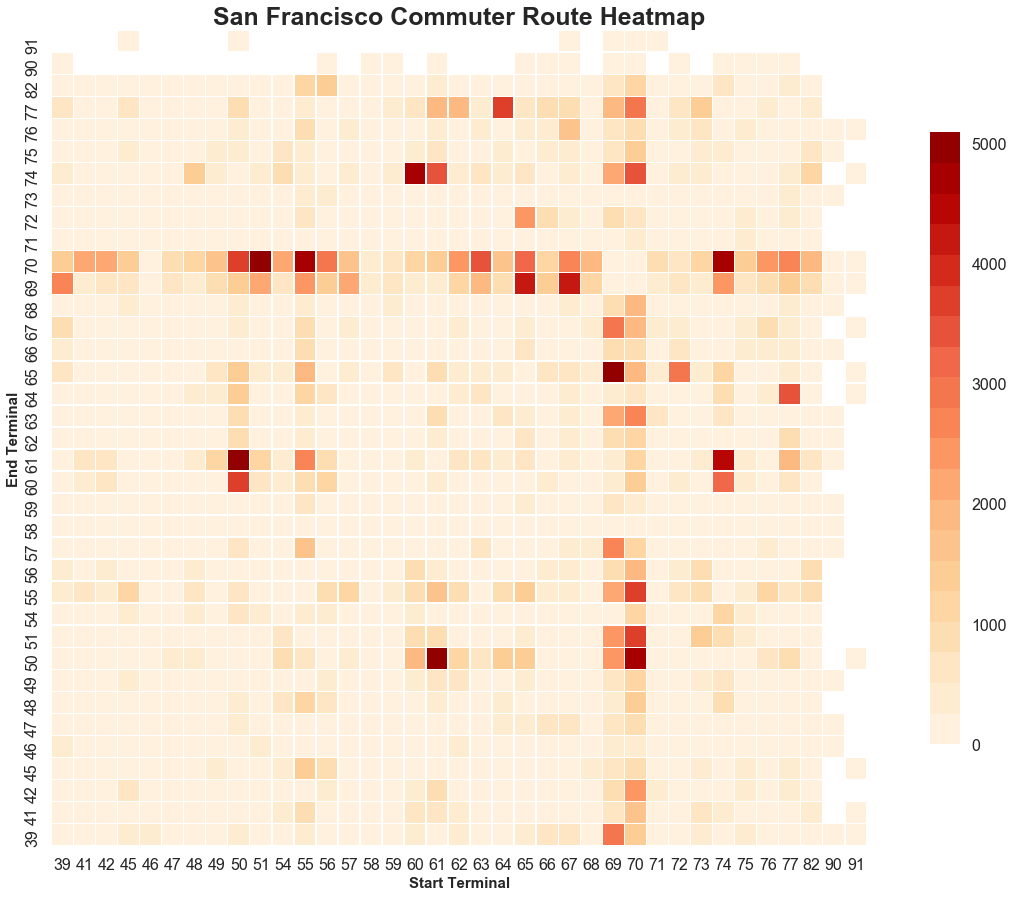

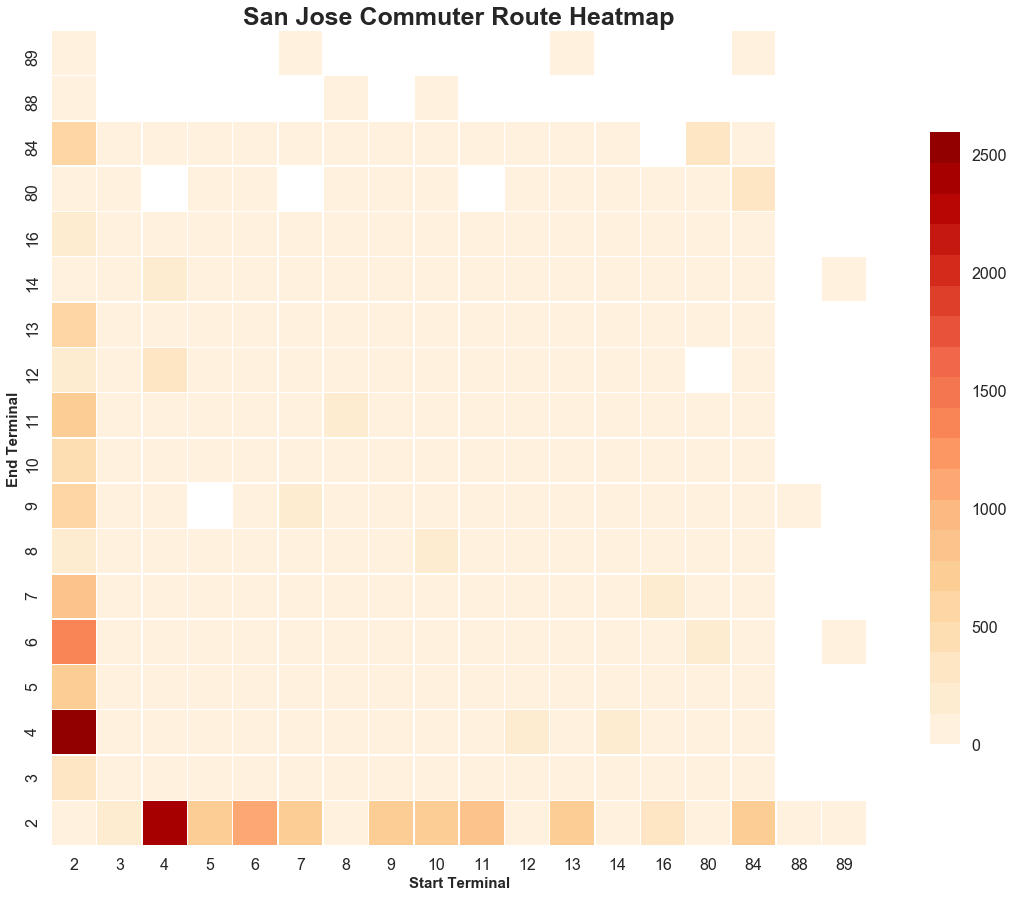

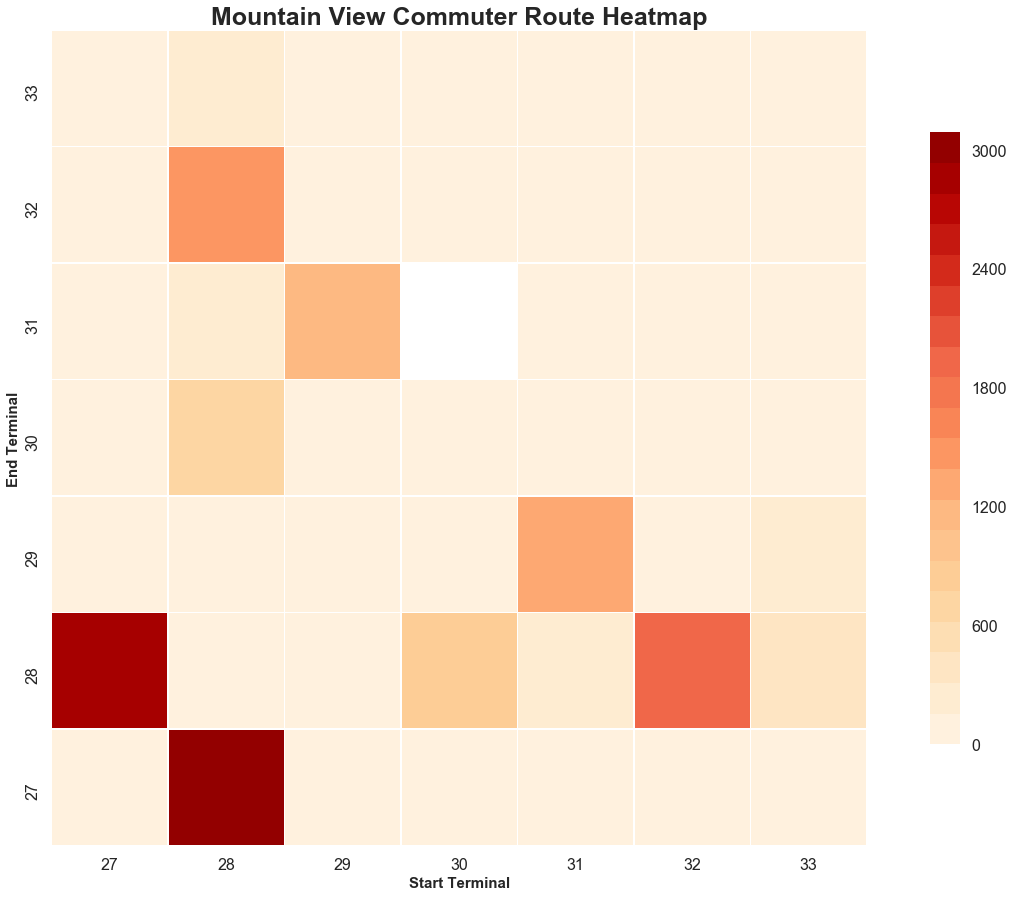

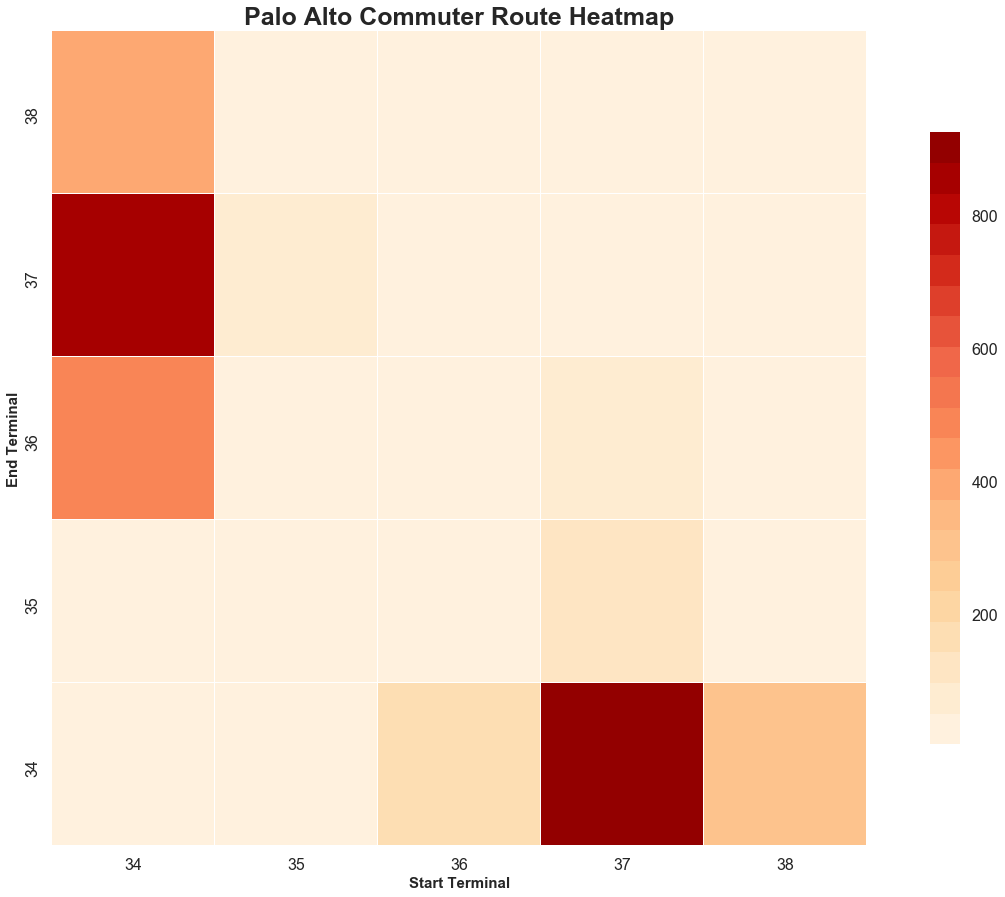

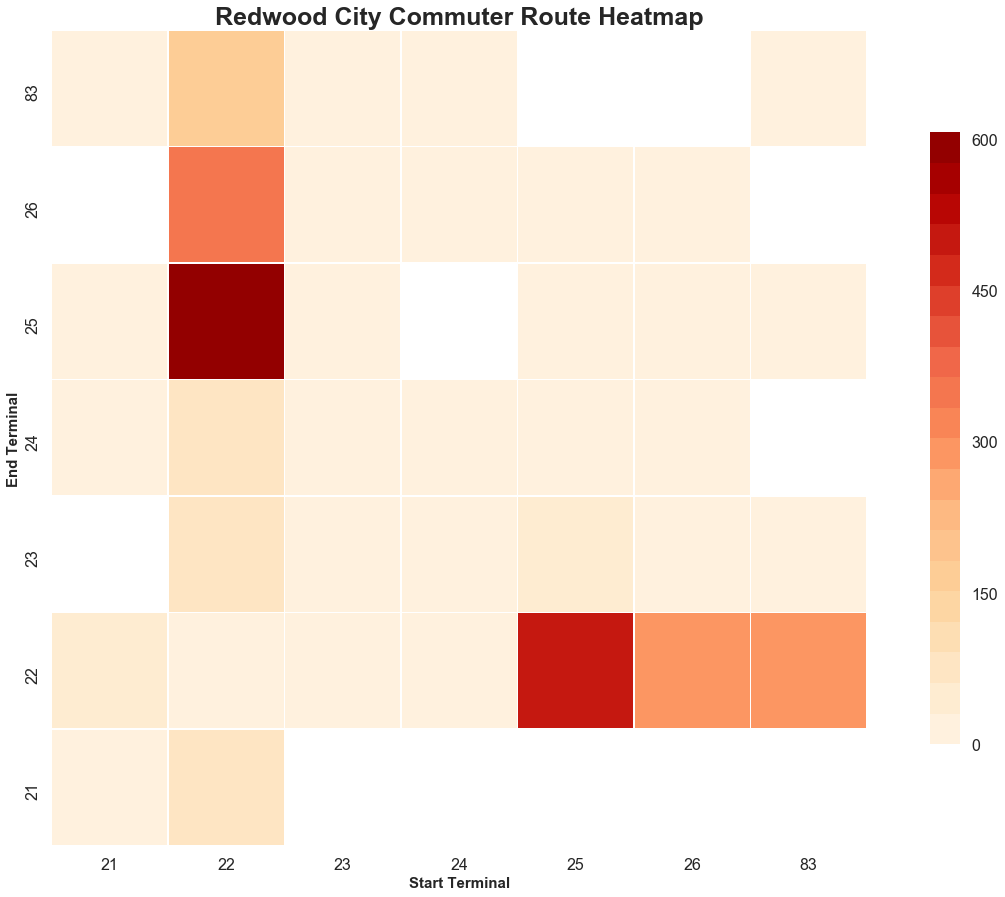

In [29]:
for zip_code in ordered_zipcodes:
    
    zip_stations = sorted(pd.unique(station_df[station_df.zip_code == zip_code]['station_id']))
    
    index   = [x for x in zip_stations]
    columns = [x for x in zip_stations]

    trip_grid = pd.DataFrame(index=index, columns=columns)
    
    # create grid of trips from start to end terminal counts
    for sid in zip_stations:
        for eid in zip_stations:
            # count trips between terminals
            route_trip_count = commuter_trips_df[(commuter_trips_df.start_terminal == sid) & (commuter_trips_df.end_terminal == eid)].shape[0]
            trip_grid.loc[eid, sid] = route_trip_count

    trip_grid = trip_grid.iloc[::-1]
    
    # drop nan rows and columns
    trip_grid.dropna(axis=0, how='all', inplace=True)
    trip_grid.dropna(axis=1, how='all', inplace=True)
    
    mask = trip_grid == 0
    grid_dims = 15
    fig, ax = plt.subplots(figsize=(grid_dims*1.5, grid_dims))
    
    sns.heatmap(data=trip_grid, linewidths=.5, square=True, cmap=sns.color_palette("OrRd", 20), mask=mask, ax=ax, cbar_kws={"shrink": .75}, cbar=True)
    
    ax.set_xlabel('Start Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('End Terminal', size=LABEL_FONT_SIZE, weight='bold')
    
    title = '%s Commuter Route Heatmap' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

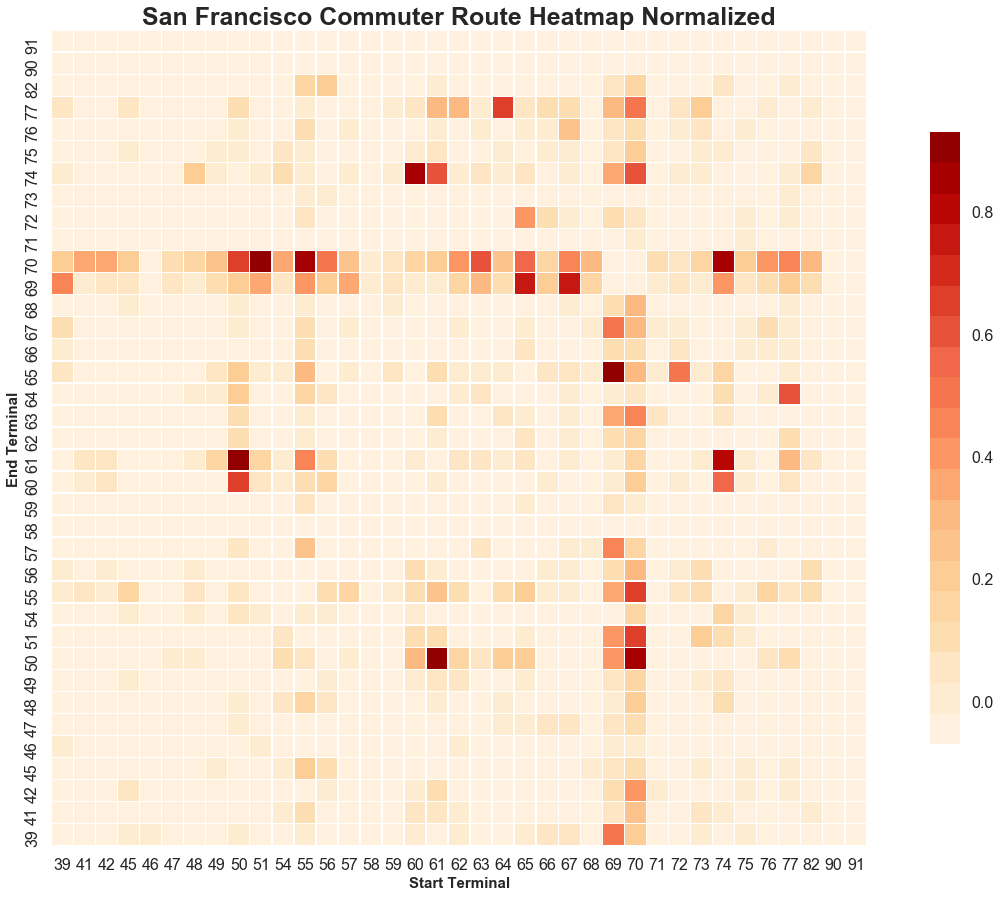

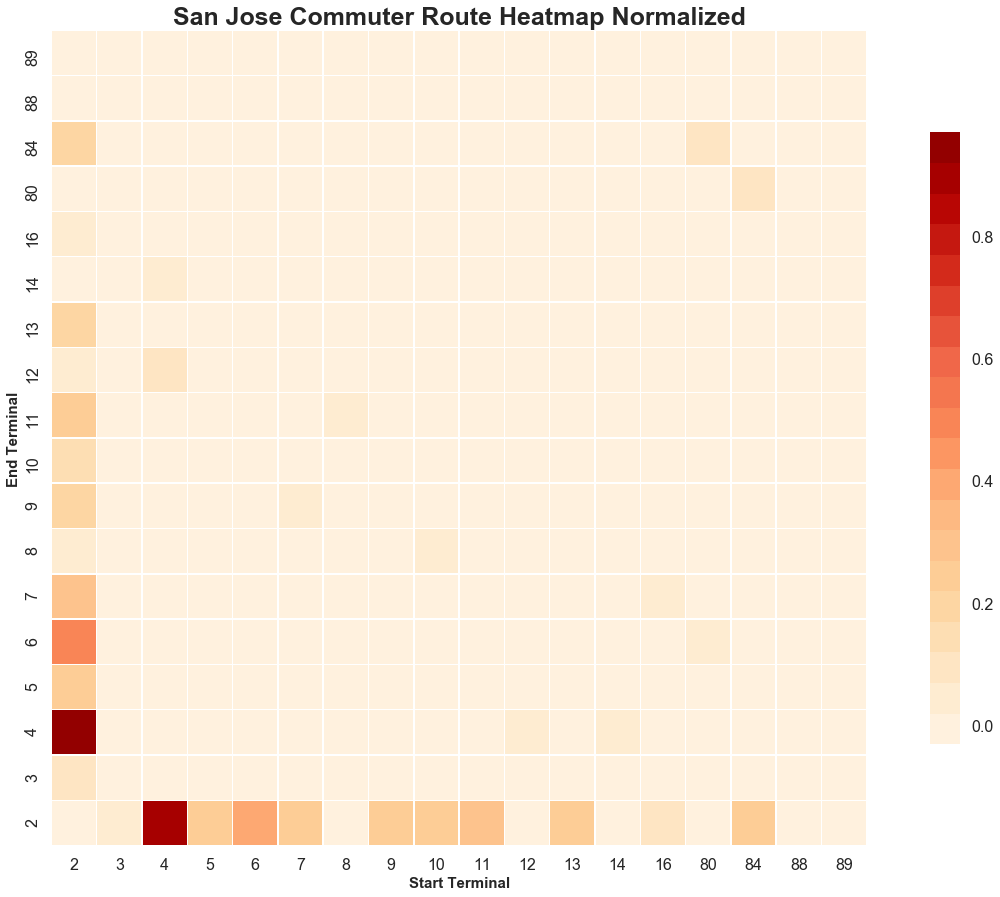

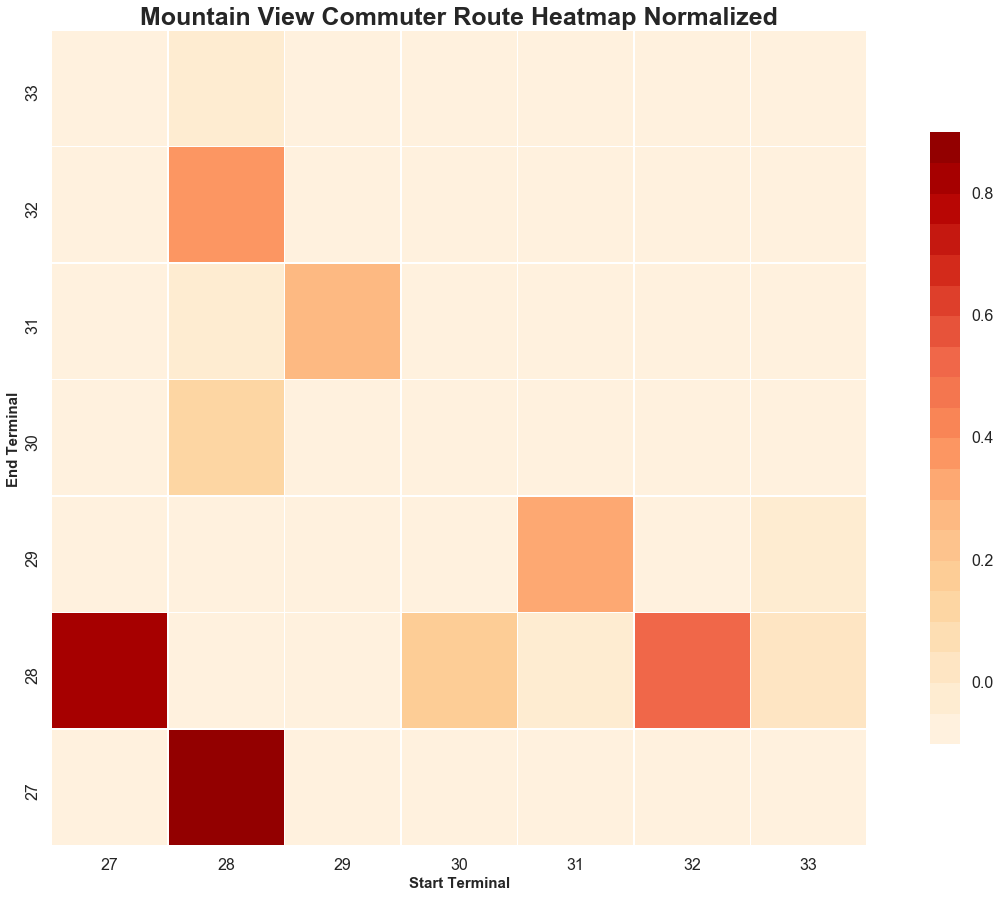

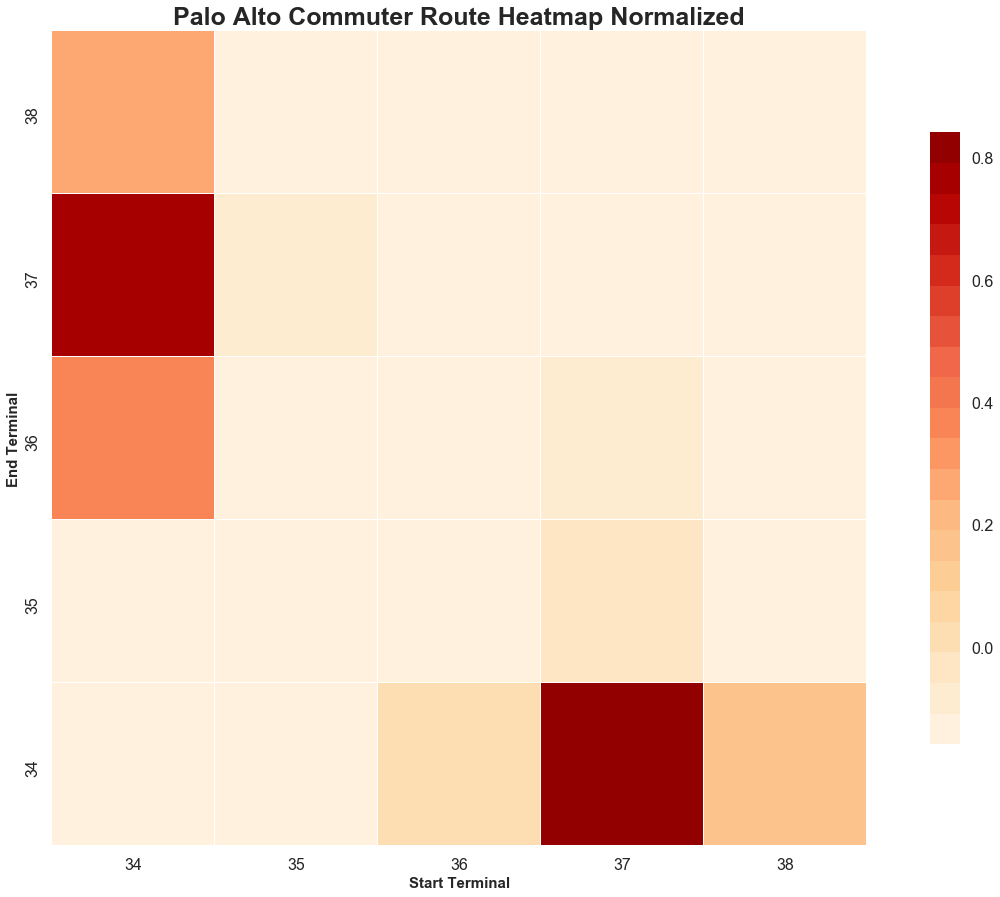

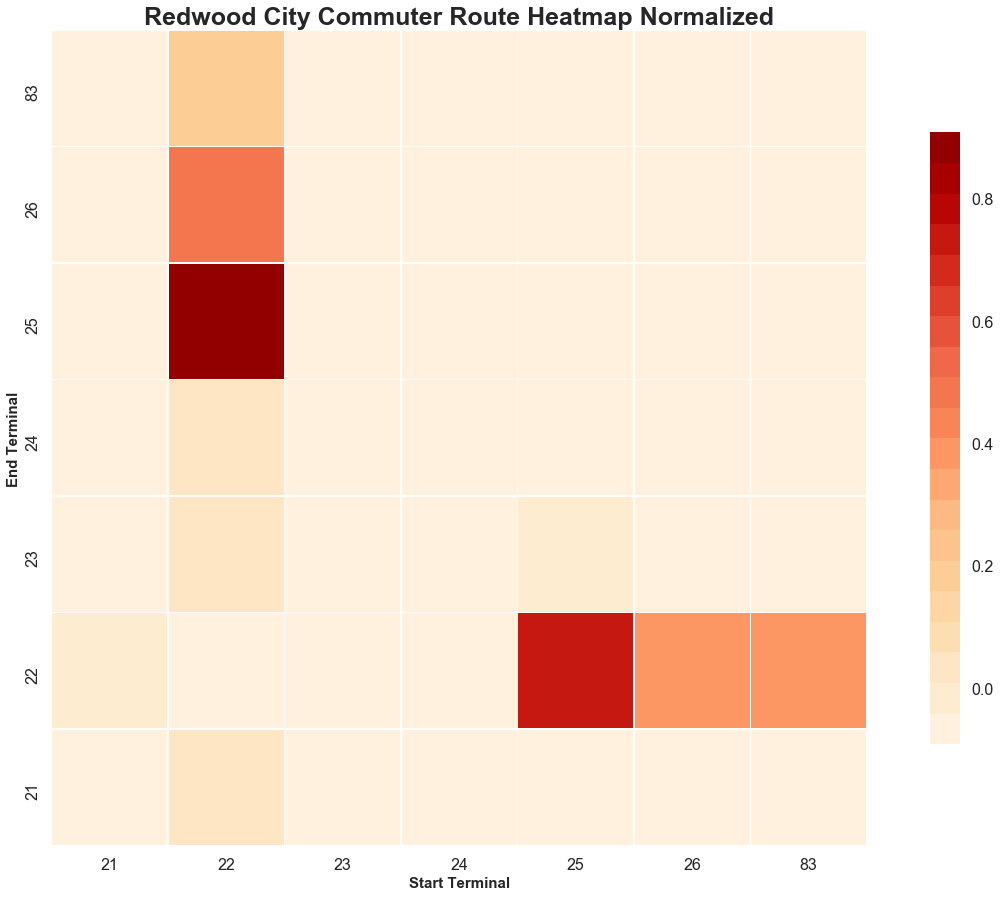

In [30]:
for zip_code in ordered_zipcodes:
    
    zip_stations = sorted(pd.unique(station_df[station_df.zip_code == zip_code]['station_id']))
    
    index   = [x for x in zip_stations]
    columns = [x for x in zip_stations]

    trip_grid = pd.DataFrame(index=index, columns=columns)
    
    # create grid of trips from start to end terminal counts
    for sid in zip_stations:
        for eid in zip_stations:
            # count trips between terminals
            route_trip_count = commuter_trips_df[(commuter_trips_df.start_terminal == sid) & (commuter_trips_df.end_terminal == eid)].shape[0]
            trip_grid.loc[eid, sid] = route_trip_count

    trip_grid = trip_grid.iloc[::-1]
    
    # drop nan rows and columns
    trip_grid.dropna(axis=0, how='all', inplace=True)
    trip_grid.dropna(axis=1, how='all', inplace=True)
    
    # normalize trip grid    
    trip_grid = (trip_grid - trip_grid.mean().mean()) / (trip_grid.max().max() - trip_grid.min().min())

    mask = trip_grid == 0
    grid_dims = 15
    fig, ax = plt.subplots(figsize=(grid_dims*1.5, grid_dims))
    
    sns.heatmap(data=trip_grid, linewidths=.5, square=True, cmap=sns.color_palette("OrRd", 20), mask=mask, ax=ax, cbar_kws={"shrink": .75}, cbar=True)
    
    ax.set_xlabel('Start Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('End Terminal', size=LABEL_FONT_SIZE, weight='bold')
    
    title = '%s Commuter Route Heatmap Normalized' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

# Identify Top Start and End Stations Used by Commuters

In [31]:
station_df.head(3)

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,...,elevation_feet,commuter_days,commuter_start_trip_count,commuter_end_trip_count,start_trip_count,end_trip_count,commuter_trip_starts_per_day,commuter_trip_ends_per_day,trip_starts_per_day,trip_ends_per_day
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,...,92.768450,785,9496,9452,13417,13149,12.096815,12.040764,12.219490,11.975410
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,...,91.988502,785,361,602,1809,2101,0.459873,0.766879,1.647541,1.913479
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,...,83.719620,785,3007,3128,5157,5017,3.830573,3.984713,4.696721,4.569217


In [32]:
for zip_code in ordered_zipcodes:
    print(zip_to_landmark(zip_code))
    print('-' * 80)
    
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('commuter_start_trip_count', ascending=False, inplace=True)
    df_trip_count = df.commuter_start_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'commuter_start_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Commuter Start Terminals by Total Trip Count')
    print('\tID -  Trips - Trip Share')
    for i, sid in enumerate(top_stations):
        trip_share = df_trip_count[i]/sum(df_trip_count)*100.
        trip_share = '{:2.4f}'.format(trip_share)
        
        print('\t%s - %s - %s - %s' % (str(sid).rjust(2), str(df_trip_count[i]).rjust(6), trip_share.rjust(7),  df_station_name[i]))
    
    print('')
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('commuter_end_trip_count', ascending=False, inplace=True)
    df_trip_count = df.commuter_end_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'commuter_end_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Commuter End Terminals by Total Trip Count')
    print('\tID -  Trips - Trip Share')
    for i, sid in enumerate(top_stations):
        trip_share = df_trip_count[i]/sum(df_trip_count)*100.
        trip_share = '{:2.4f}'.format(trip_share)
        
        print('\t%s - %s - %s - %s' % (str(sid).rjust(2), str(df_trip_count[i]).rjust(6), trip_share.rjust(7),  df_station_name[i]))

    print('')

San Francisco
--------------------------------------------------------------------------------
Top Commuter Start Terminals by Total Trip Count
	ID -  Trips - Trip Share
	70 -  51338 - 19.4084 - San Francisco Caltrain (Townsend at 4th)
	69 -  39558 - 14.9550 - San Francisco Caltrain 2 (330 Townsend)
	55 -  28970 - 10.9522 - Temporary Transbay Terminal (Howard at Beale)
	50 -  25207 -  9.5296 - Harry Bridges Plaza (Ferry Building)
	74 -  24455 -  9.2453 - Steuart at Market
	61 -  23499 -  8.8838 - 2nd at Townsend
	65 -  20342 -  7.6903 - Townsend at 7th
	77 -  18309 -  6.9218 - Market at Sansome
	67 -  16712 -  6.3180 - Market at 10th
	60 -  16124 -  6.0957 - Embarcadero at Sansome

Top Commuter End Terminals by Total Trip Count
	ID -  Trips - Trip Share
	70 -  66745 - 23.3390 - San Francisco Caltrain (Townsend at 4th)
	69 -  41813 - 14.6210 - San Francisco Caltrain 2 (330 Townsend)
	61 -  25785 -  9.0164 - 2nd at Townsend
	50 -  25344 -  8.8622 - Harry Bridges Plaza (Ferry Building)
	5

# Split Trips into Morning and Evening Commute Hours

In [33]:
morning_commuter_trips_df.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,humidity,precipIntensity,precipProbability,precipType,pressure,temperature,forecast_time,visibility,windBearing,windSpeed
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,0.92,0.0,0.0,0.0,1017.06,62.63,2013-08-29 09:00:00,10.0,183.0,0.7
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0


In [34]:
evening_commuter_trips_df.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,humidity,precipIntensity,precipProbability,precipType,pressure,temperature,forecast_time,visibility,windBearing,windSpeed
375,4672,1251,2013-08-29 15:44:00,Harry Bridges Plaza (Ferry Building),50,2013-08-29 16:05:00,San Francisco Caltrain (Townsend at 4th),70,583,Subscriber,...,0.67,0.0,0.0,0.0,1016.68,70.61,2013-08-29 15:00:00,10.0,256.0,7.18
378,4676,684,2013-08-29 15:49:00,Townsend at 7th,65,2013-08-29 16:01:00,Civic Center BART (7th at Market),72,417,Subscriber,...,0.69,0.0,0.0,0.0,1017.12,69.64,2013-08-29 15:00:00,10.0,270.0,7.92
381,4679,440,2013-08-29 15:54:00,Golden Gate at Polk,59,2013-08-29 16:02:00,Civic Center BART (7th at Market),72,397,Subscriber,...,0.69,0.0,0.0,0.0,1017.14,69.40,2013-08-29 15:00:00,10.0,268.0,7.96


## Append Morning Commute Station Data

In [35]:
# for each station, get count of rides started from that station between first and last service dates

# append data from only trips by commuters
station_df['morning_commuter_start_trip_count'] = station_df.apply(lambda row: trips_per_day (row, trips_df=morning_commuter_trips_df, which='start'), axis=1)
station_df['morning_commuter_end_trip_count']   = station_df.apply(lambda row: trips_per_day (row, trips_df=morning_commuter_trips_df, which='end'), axis=1)

# Calculate Trips per day
station_df['morning_commuter_trip_starts_per_day'] = station_df['morning_commuter_start_trip_count'] / station_df['commuter_days']
station_df['morning_commuter_trip_ends_per_day']   = station_df['morning_commuter_end_trip_count'] / station_df['commuter_days']

## Append Evening Commute Station Data

In [36]:
# for each station, get count of rides started from that station between first and last service dates

# append data from only trips by commuters
station_df['evening_commuter_start_trip_count'] = station_df.apply(lambda row: trips_per_day (row, trips_df=evening_commuter_trips_df, which='start'), axis=1)
station_df['evening_commuter_end_trip_count']   = station_df.apply(lambda row: trips_per_day (row, trips_df=evening_commuter_trips_df, which='end'), axis=1)

# Calculate Trips per day
station_df['evening_commuter_trip_starts_per_day'] = station_df['evening_commuter_start_trip_count'] / station_df['commuter_days']
station_df['evening_commuter_trip_ends_per_day']   = station_df['evening_commuter_end_trip_count'] / station_df['commuter_days']

In [37]:
station_df.columns

Index(['station_id', 'name', 'lat', 'long', 'dock_count', 'landmark',
       'first_service_date', 'last_service_date', 'zip_code',
       'days_in_service', 'elevation_meters', 'elevation_feet',
       'commuter_days', 'commuter_start_trip_count', 'commuter_end_trip_count',
       'start_trip_count', 'end_trip_count', 'commuter_trip_starts_per_day',
       'commuter_trip_ends_per_day', 'trip_starts_per_day',
       'trip_ends_per_day', 'morning_commuter_start_trip_count',
       'morning_commuter_end_trip_count',
       'morning_commuter_trip_starts_per_day',
       'morning_commuter_trip_ends_per_day',
       'evening_commuter_start_trip_count', 'evening_commuter_end_trip_count',
       'evening_commuter_trip_starts_per_day',
       'evening_commuter_trip_ends_per_day'],
      dtype='object')

## Plot Heatmap of Morning Routes

In [38]:
morning_commuter_trips_df.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,humidity,precipIntensity,precipProbability,precipType,pressure,temperature,forecast_time,visibility,windBearing,windSpeed
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,0.92,0.0,0.0,0.0,1017.06,62.63,2013-08-29 09:00:00,10.0,183.0,0.7
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,0.91,0.0,0.0,0.0,1017.26,62.60,2013-08-29 09:00:00,10.0,241.0,1.0


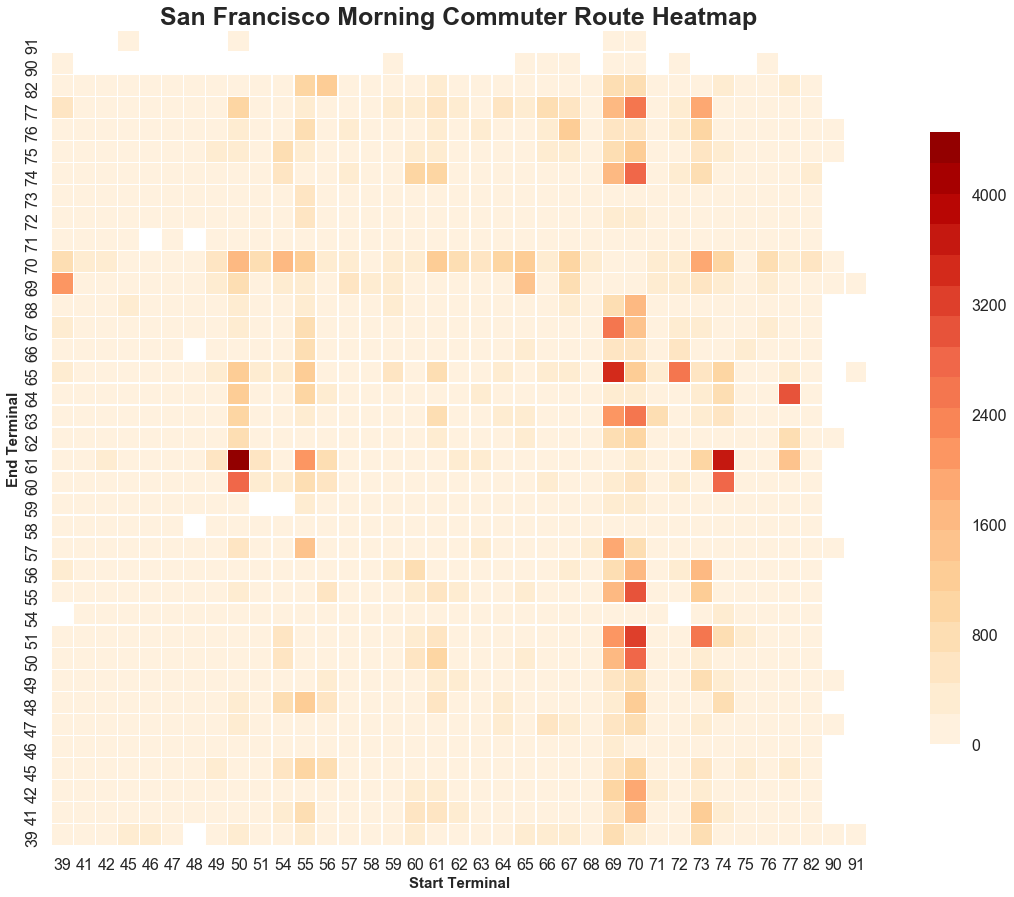

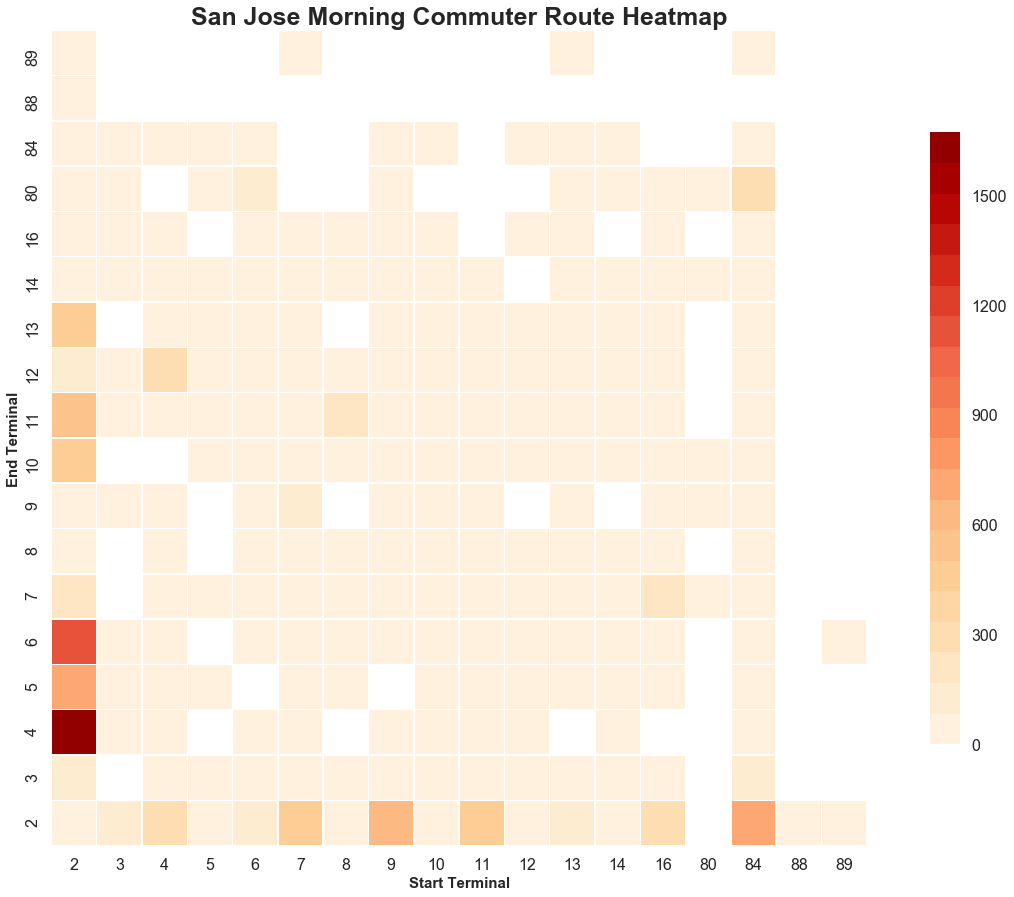

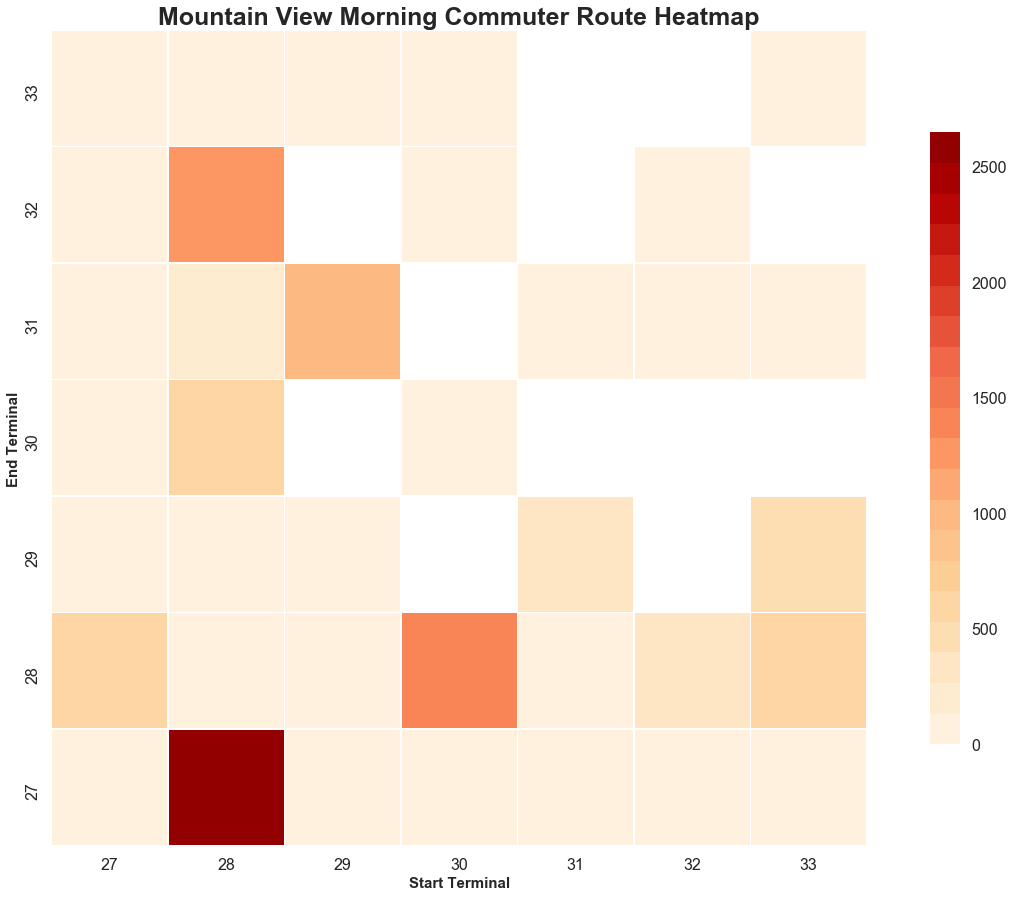

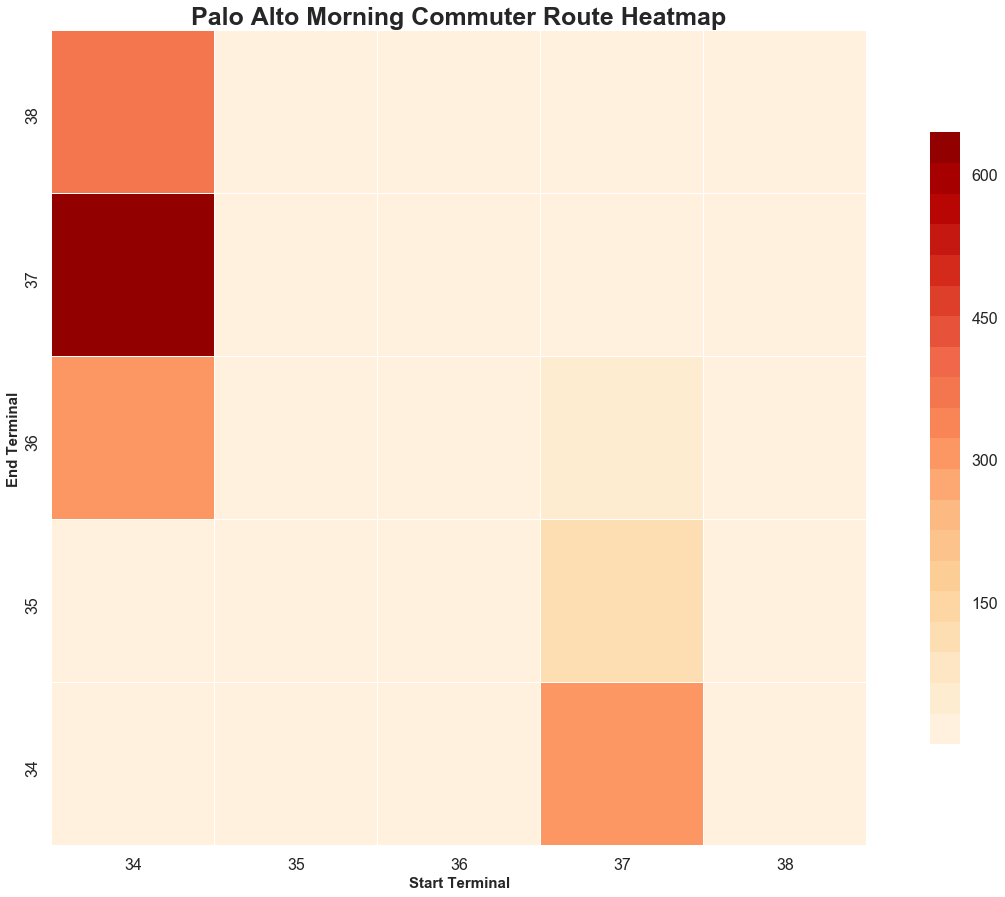

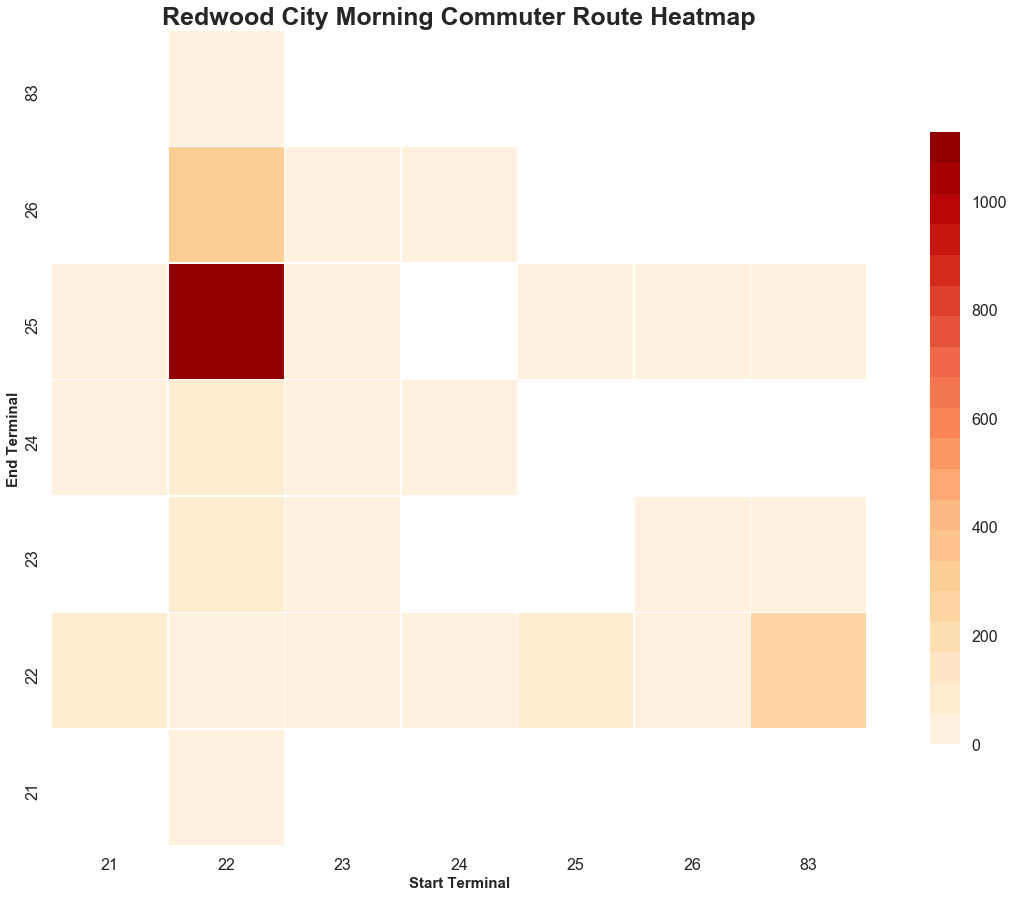

In [33]:
for zip_code in ordered_zipcodes:

    df = morning_commuter_trips_df[(morning_commuter_trips_df.start_zip == zip_code) & (morning_commuter_trips_df.end_zip == zip_code)].copy()

    start_stations = sorted(pd.unique(df.start_terminal))
    end_stations = sorted(pd.unique(df.end_terminal))

    stations = start_stations

    for s in end_stations:
        if s not in stations:
            stations.append(s)

    index   = [x for x in stations]
    columns = [x for x in stations]

    trip_grid = pd.DataFrame(index=index, columns=columns)

    # create grid of trips from start to end terminal counts
    for sid in stations:
        for eid in stations:
            # count trips between terminals
            route_trip_count = df[(df.start_terminal == sid) & (df.end_terminal == eid)].shape[0]
            trip_grid.loc[eid, sid] = route_trip_count

    trip_grid = trip_grid.iloc[::-1]

    # drop nan rows and columns
    trip_grid.dropna(axis=0, how='all', inplace=True)
    trip_grid.dropna(axis=1, how='all', inplace=True)

    mask = trip_grid == 0
    grid_dims = 15
    fig, ax = plt.subplots(figsize=(grid_dims*1.5, grid_dims))

    sns.heatmap(data=trip_grid, linewidths=.5, square=True, cmap=sns.color_palette("OrRd", 20), mask=mask, ax=ax, cbar_kws={"shrink": .75}, cbar=True)

    ax.set_xlabel('Start Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('End Terminal', size=LABEL_FONT_SIZE, weight='bold')

    title = '%s Morning Commuter Route Heatmap' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

In [39]:
for zip_code in ordered_zipcodes:
    print(zip_to_landmark(zip_code))
    print('-' * 80)
    
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('morning_commuter_start_trip_count', ascending=False, inplace=True)
    df_trip_count = df.morning_commuter_start_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'morning_commuter_start_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Morning Commuter Start Terminals by Total Trip Count')
    print('\tID -  Trips - Trip Share')
    for i, sid in enumerate(top_stations):
        trip_share = df_trip_count[i]/sum(df_trip_count)*100.
        trip_share = '{:2.4f}'.format(trip_share)
        
        print('\t%s - %s - %s - %s' % (str(sid).rjust(2), str(df_trip_count[i]).rjust(6), trip_share.rjust(7),  df_station_name[i]))
    
    print('')
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('morning_commuter_end_trip_count', ascending=False, inplace=True)
    df_trip_count = df.morning_commuter_end_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'morning_commuter_end_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Morning Commuter End Terminals by Total Trip Count')
    print('\tID -  Trips - Trip Share')
    for i, sid in enumerate(top_stations):
        trip_share = df_trip_count[i]/sum(df_trip_count)*100.
        trip_share = '{:2.4f}'.format(trip_share)
        
        print('\t%s - %s - %s - %s' % (str(sid).rjust(2), str(df_trip_count[i]).rjust(6), trip_share.rjust(7),  df_station_name[i]))

    print('')

San Francisco
--------------------------------------------------------------------------------
Top Morning Commuter Start Terminals by Total Trip Count
	ID -  Trips - Trip Share
	70 -  38357 - 23.7627 - San Francisco Caltrain (Townsend at 4th)
	69 -  29952 - 18.5557 - San Francisco Caltrain 2 (330 Townsend)
	50 -  19222 - 11.9083 - Harry Bridges Plaza (Ferry Building)
	55 -  19128 - 11.8501 - Temporary Transbay Terminal (Howard at Beale)
	74 -  14516 -  8.9929 - Steuart at Market
	61 -  10568 -  6.5470 - 2nd at Townsend
	77 -   7608 -  4.7133 - Market at Sansome
	67 -   7532 -  4.6662 - Market at 10th
	54 -   7344 -  4.5497 - Embarcadero at Bryant
	72 -   7190 -  4.4543 - Civic Center BART (7th at Market)

Top Morning Commuter End Terminals by Total Trip Count
	ID -  Trips - Trip Share
	70 -  20657 - 15.9931 - San Francisco Caltrain (Townsend at 4th)
	61 -  17031 - 13.1858 - 2nd at Townsend
	65 -  16512 - 12.7839 - Townsend at 7th
	77 -  12740 -  9.8636 - Market at Sansome
	69 -  10809

## Plot Heatmap of Evening Routes

In [40]:
evening_commuter_trips_df.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,humidity,precipIntensity,precipProbability,precipType,pressure,temperature,forecast_time,visibility,windBearing,windSpeed
375,4672,1251,2013-08-29 15:44:00,Harry Bridges Plaza (Ferry Building),50,2013-08-29 16:05:00,San Francisco Caltrain (Townsend at 4th),70,583,Subscriber,...,0.67,0.0,0.0,0.0,1016.68,70.61,2013-08-29 15:00:00,10.0,256.0,7.18
378,4676,684,2013-08-29 15:49:00,Townsend at 7th,65,2013-08-29 16:01:00,Civic Center BART (7th at Market),72,417,Subscriber,...,0.69,0.0,0.0,0.0,1017.12,69.64,2013-08-29 15:00:00,10.0,270.0,7.92
381,4679,440,2013-08-29 15:54:00,Golden Gate at Polk,59,2013-08-29 16:02:00,Civic Center BART (7th at Market),72,397,Subscriber,...,0.69,0.0,0.0,0.0,1017.14,69.40,2013-08-29 15:00:00,10.0,268.0,7.96


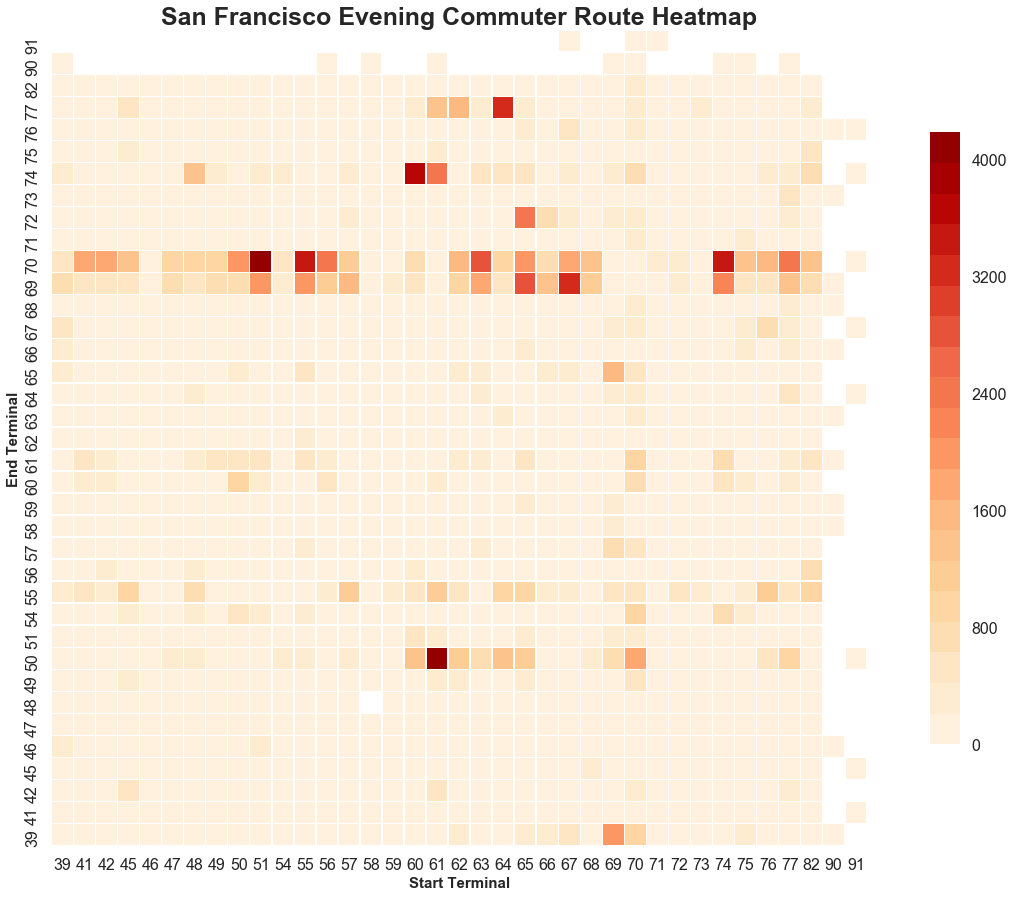

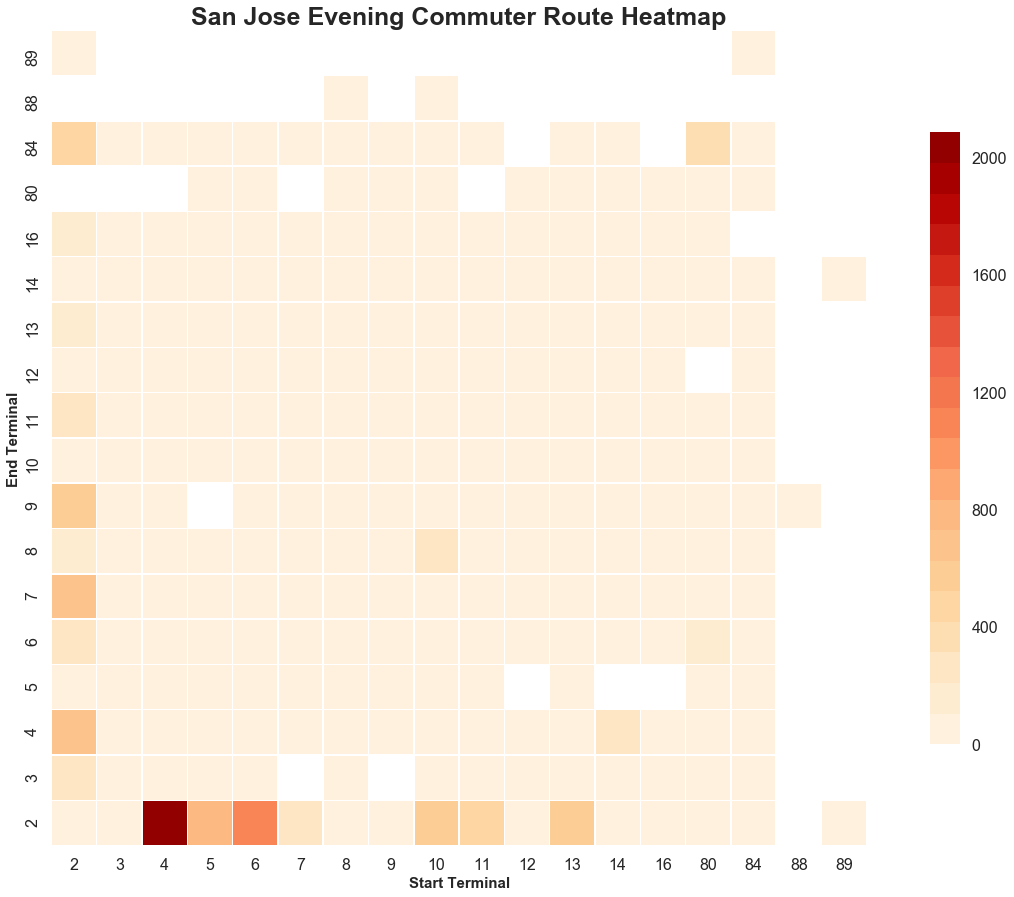

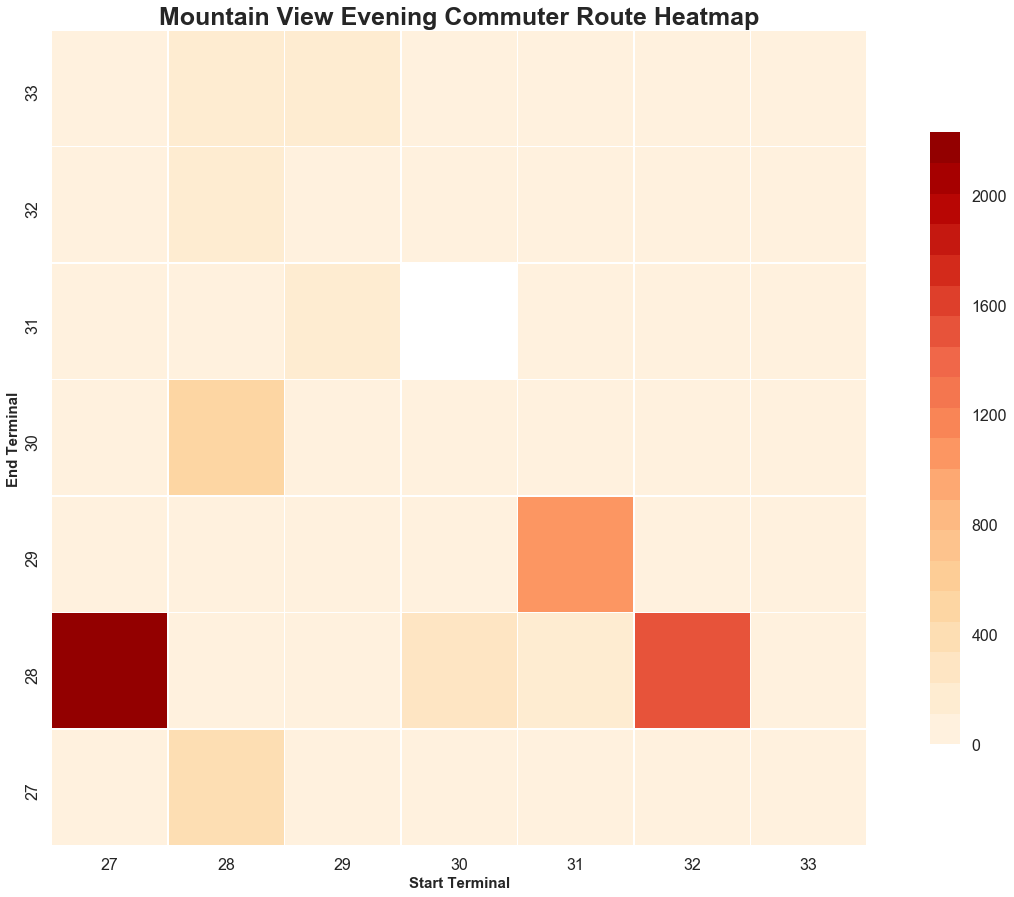

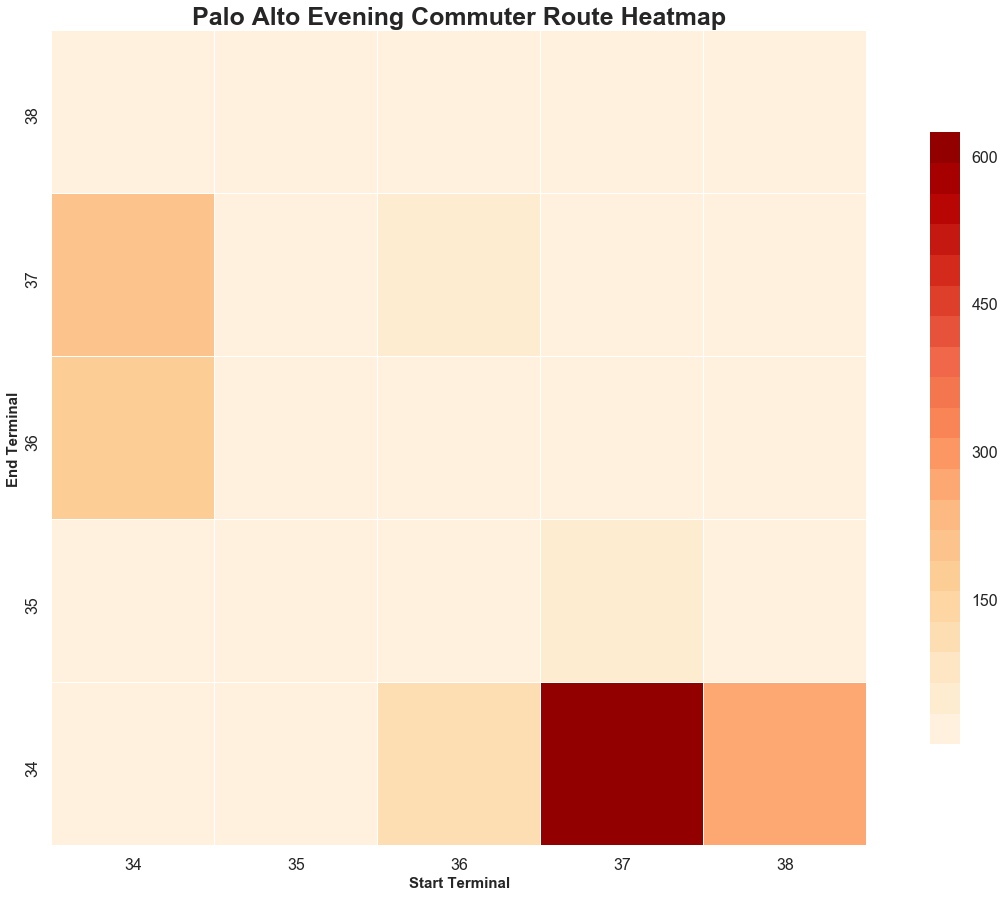

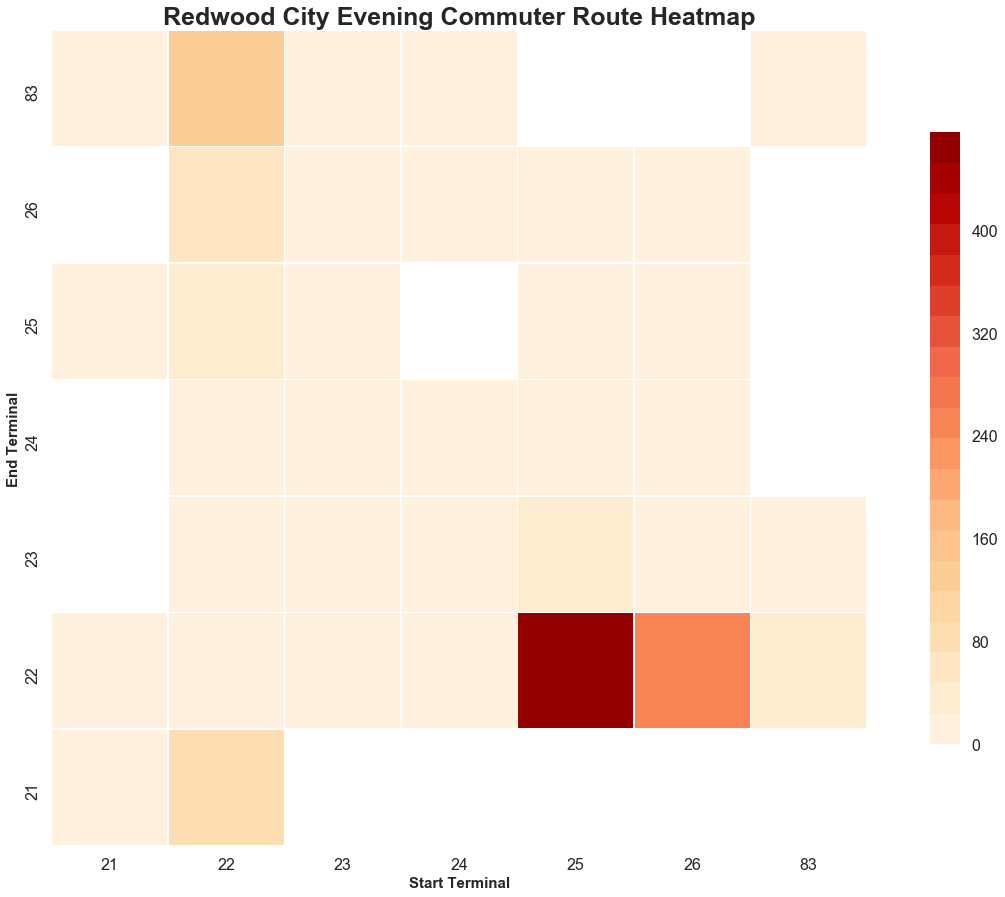

In [41]:
for zip_code in ordered_zipcodes:

    df = evening_commuter_trips_df[(evening_commuter_trips_df.start_zip == zip_code) & (evening_commuter_trips_df.end_zip == zip_code)].copy()

    start_stations = sorted(pd.unique(df.start_terminal))
    end_stations = sorted(pd.unique(df.end_terminal))

    stations = start_stations

    for s in end_stations:
        if s not in stations:
            stations.append(s)

    index   = [x for x in stations]
    columns = [x for x in stations]

    trip_grid = pd.DataFrame(index=index, columns=columns)

    # create grid of trips from start to end terminal counts
    for sid in stations:
        for eid in stations:
            # count trips between terminals
            route_trip_count = df[(df.start_terminal == sid) & (df.end_terminal == eid)].shape[0]
            trip_grid.loc[eid, sid] = route_trip_count

    trip_grid = trip_grid.iloc[::-1]

    # drop nan rows and columns
    trip_grid.dropna(axis=0, how='all', inplace=True)
    trip_grid.dropna(axis=1, how='all', inplace=True)

    mask = trip_grid == 0
    grid_dims = 15
    fig, ax = plt.subplots(figsize=(grid_dims*1.5, grid_dims))

    sns.heatmap(data=trip_grid, linewidths=.5, square=True, cmap=sns.color_palette("OrRd", 20), mask=mask, ax=ax, cbar_kws={"shrink": .75}, cbar=True)

    ax.set_xlabel('Start Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('End Terminal', size=LABEL_FONT_SIZE, weight='bold')

    title = '%s Evening Commuter Route Heatmap' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

In [42]:
for zip_code in ordered_zipcodes:
    print(zip_to_landmark(zip_code))
    print('-' * 80)
    
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('evening_commuter_start_trip_count', ascending=False, inplace=True)
    df_trip_count = df.evening_commuter_start_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'evening_commuter_start_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Evening Commuter Start Terminals by Total Trip Count')
    print('\tID -  Trips - Trip Share')
    for i, sid in enumerate(top_stations):
        trip_share = df_trip_count[i]/sum(df_trip_count)*100.
        trip_share = '{:2.4f}'.format(trip_share)
        
        print('\t%s - %s - %s - %s' % (str(sid).rjust(2), str(df_trip_count[i]).rjust(6), trip_share.rjust(7),  df_station_name[i]))
    
    print('')
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('evening_commuter_end_trip_count', ascending=False, inplace=True)
    df_trip_count = df.evening_commuter_end_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'evening_commuter_end_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Evening Commuter End Terminals by Total Trip Count')
    print('\tID -  Trips - Trip Share')
    for i, sid in enumerate(top_stations):
        trip_share = df_trip_count[i]/sum(df_trip_count)*100.
        trip_share = '{:2.4f}'.format(trip_share)
        
        print('\t%s - %s - %s - %s' % (str(sid).rjust(2), str(df_trip_count[i]).rjust(6), trip_share.rjust(7),  df_station_name[i]))

    print('')

San Francisco
--------------------------------------------------------------------------------
Top Evening Commuter Start Terminals by Total Trip Count
	ID -  Trips - Trip Share
	65 -  13958 - 12.7119 - Townsend at 7th
	70 -  12981 - 11.8221 - San Francisco Caltrain (Townsend at 4th)
	61 -  12931 - 11.7765 - 2nd at Townsend
	77 -  10701 -  9.7456 - Market at Sansome
	64 -  10262 -  9.3458 - 2nd at South Park
	60 -  10131 -  9.2265 - Embarcadero at Sansome
	74 -   9939 -  9.0517 - Steuart at Market
	55 -   9842 -  8.9633 - Temporary Transbay Terminal (Howard at Beale)
	69 -   9606 -  8.7484 - San Francisco Caltrain 2 (330 Townsend)
	51 -   9452 -  8.6081 - Embarcadero at Folsom

Top Evening Commuter End Terminals by Total Trip Count
	ID -  Trips - Trip Share
	70 -  46088 - 28.3305 - San Francisco Caltrain (Townsend at 4th)
	69 -  31004 - 19.0583 - San Francisco Caltrain 2 (330 Townsend)
	50 -  17246 - 10.6012 - Harry Bridges Plaza (Ferry Building)
	55 -  14770 -  9.0792 - Temporary Tran

# Station Balance at Top Commuter Stations
<ul>Top Commuter Stations
	<li><b>Station 70 :</b> San Francisco Caltrain (Townsend at 4th)</li>
	<li><b>Station 69 :</b> San Francisco Caltrain 2 (330 Townsend)</li>
	<li><b>Station 50 :</b> Harry Bridges Plaza (Ferry Building)</li>
	<li><b>Station 55 :</b> Temporary Transbay Terminal (Howard at Beale)</li>
	<li><b>Station 74 :</b> Steuart at Market</li>
</ul>